<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/SigLip_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!curl -L http://i.imgur.com/8o9DXSj.jpeg --output image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44094  100 44094    0     0   219k      0 --:--:-- --:--:-- --:--:--  219k


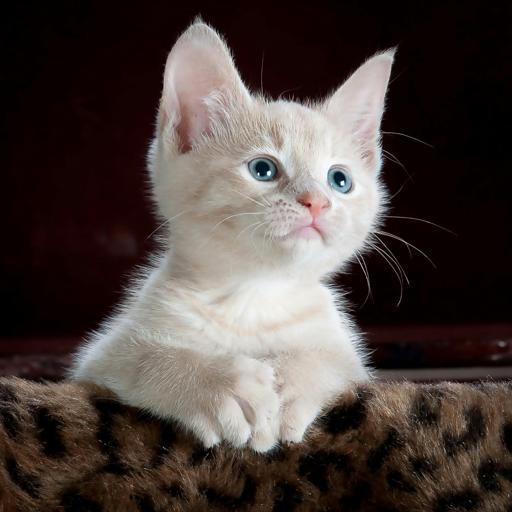

In [9]:
from PIL import Image

img = Image.open("image.jpg")
img

In [10]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=Tr

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms

In [15]:
def preprocess_image(image, image_size=224):
  preprocess = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )
  ])

  image_tensor = preprocess(image)
  # (3, 224, 244) -> unsqueeze -> (1, 3, 224, 224)
  image_tensor = image_tensor.unsqueeze(0)

  return image_tensor

In [20]:
image_tensor = preprocess_image(img)

embed_dim = 768
patch_size = 15
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
  patch_embedding = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
  patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

In [17]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand(1, -1)
position_ids.shape

torch.Size([1, 196])

In [19]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) -> (1, 196, 768)
embeddings = embeddings.transpose(1,2)
embeddings = embeddings + position_embedding(position_ids)
embeddings.shape

torch.Size([1, 196, 768])

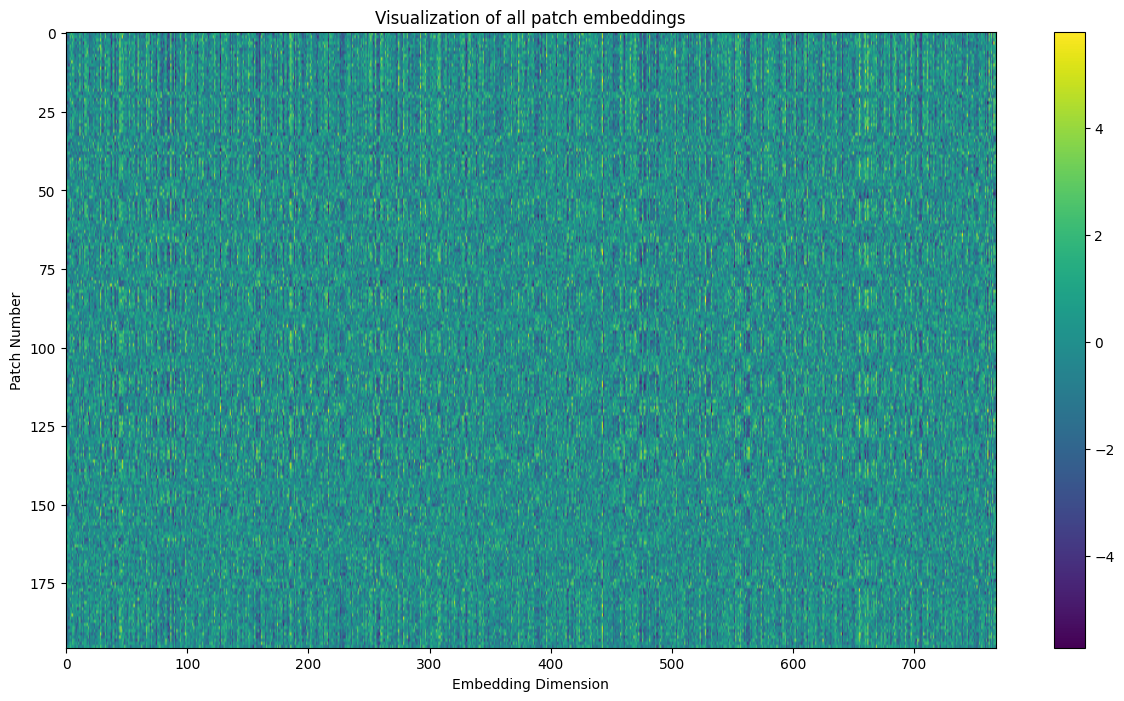

In [23]:
import matplotlib.pyplot as plt

# it should look all random, since the weights are random at the initialization
# Visualize all patch embeddings

patches_viz = embeddings[0].detach().numpy() # (196, 768)

plt.figure(figsize=(15,8))
plt.imshow(patches_viz, aspect="auto", cmap="viridis")
plt.colorbar()
plt.title("Visualization of all patch embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Patch Number")
plt.show()

torch.Size([1, 196, 768])


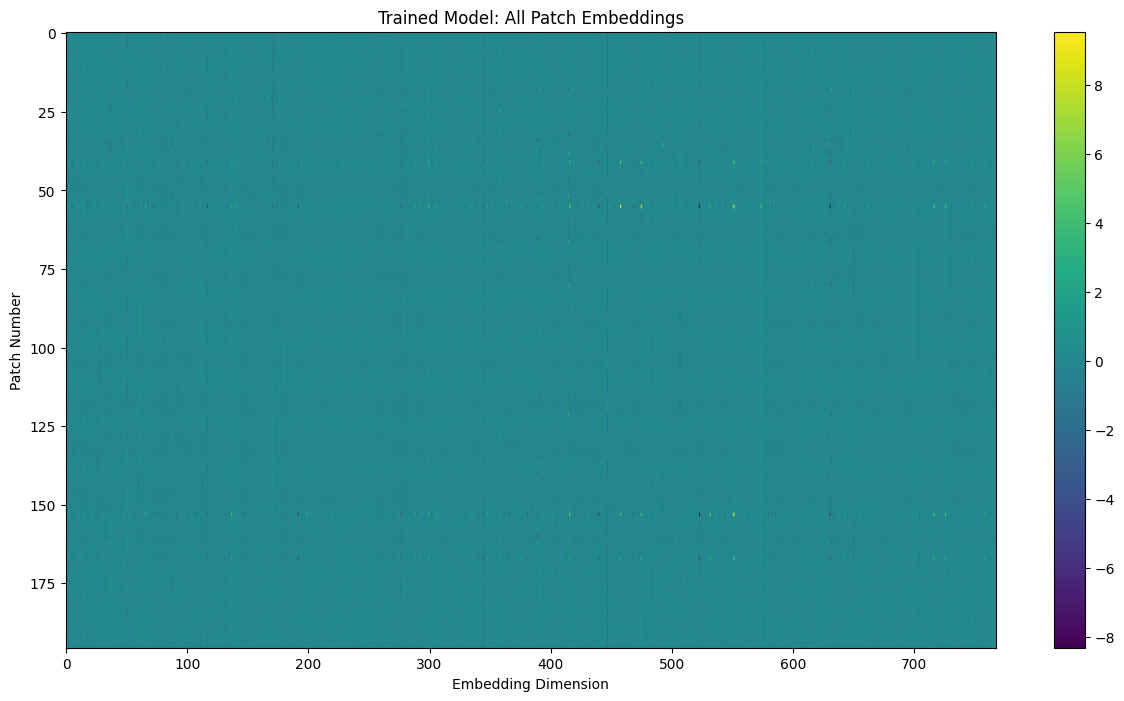

In [29]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
  patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)
patches_viz = patch_embeddings[0].detach().numpy() # (196, 768)

plt.figure(figsize=(15,8))
plt.imshow(patches_viz, aspect="auto", cmap="viridis")
plt.colorbar()
plt.title("Trained Model: All Patch Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Patch Number")
plt.show()

In [30]:
@dataclass
class SiglipVisionConfig:
  num_channels: int = 3
  embed_dim: int = 768
  image_size: int = 224
  patch_size: int = 16

class SiglipVisionEmbeddings(nn.Module):

  def __init__(self, config: SiglipVisionConfig):
    super().__init__()
    self.config = config
    self.num_channels = config.num_channels
    self.embed_dim = config.embed_dim
    self.image_size = config.image_size
    self.patch_size = config.patch_size

    self.patch_embedding = nn.Conv2d(
        in_channels=self.num_channels,
        out_channels=self.embed_dim,
        kernel_size=self.patch_size,
        stride=self.patch_size,
        padding="valid"
    )

    self.num_patches = (self.image_size // self.patch_size) ** 2
    self.num_positions = self.num_patches
    self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
    self.register_buffer(
        "position_ids",
        torch.arange(self.num_positions).expand((1, -1)),
        persistent=False
    )

  def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
    B, C, H, W = pixel_values.shape
    patch_embeds = self.patch_embedding(pixel_values)
    embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
    embeddings = embeddings.transpose(1,2)
    embeddings = embeddings + self.position_embedding(self.position_ids)
    return embeddings

In [31]:
embd = SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape # (1, 196, 768)

torch.Size([1, 196, 768])

In [33]:
from transformers import SiglipVisionModel as HFSiglipVisionModel

our_state_dict = embd.state_dict()
hf_state_dict = {
    k.replace("vision_model.embeddings.", ""): v for k,v in vision_model.state_dict().items()
  if "vision_model.embeddings." in k
}
our_state_dict.update(hf_state_dict)
embd.load_state_dict(our_state_dict)

with torch.no_grad():
  our_output = embd(image_tensor)
  hf_output = vision_model.vision_model.embeddings(image_tensor)
  print("Max difference between our output and HF output:", torch.max(torch.abs(our_output - hf_output)))

Max difference between our output and HF output: tensor(0.)


In [37]:
import math

class Head(nn.Module):
  """ A single head of the multi-head attention """

  def __init__(self, n_in, n_head, context_length):
    super().__init__()
    self.head_size = n_head
    self.key = nn.Linear(n_in, n_head, bias=False)
    self.query = nn.Linear(n_in, n_head, bias=False)
    self.value = nn.Linear(n_in, n_head, bias=False)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)
    q = self.query(x)
    v = self.value(x)
    wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
    wei = F.softmax(wei, dim=-1)
    out = wei @ v
    return out

class MultiHeadAttention(nn.Module):
  """ Mult-head attention implemenation with concatenating every head's output """
  def __init__(self, num_head, n_in, head_size, context_length):
    super().__init__()
    self.head_size = head_size
    self.num_head = num_head
    self.heads = [Head(n_in, head_size, context_length) for _ in range(num_head)]
    self.proj = nn.Linear(n_in, n_in)

  def forward(self, x):
    out = [h(x) for h in self.heads]
    out = torch.concat(out, -1)
    out = self.proj(out)
    return out

In [38]:
num_attention_heads = 12
hidden_size = 768

attn = MultiHeadAttention(num_head=12, n_in=768, head_size=64, context_length=196)
attn(torch.randn(1, 196, 768))

tensor([[[-0.0111,  0.0038,  0.0147,  ...,  0.0462,  0.0133, -0.0172],
         [ 0.0046,  0.0015,  0.0023,  ...,  0.0535,  0.0074, -0.0061],
         [ 0.0042, -0.0078,  0.0009,  ...,  0.0484,  0.0101,  0.0042],
         ...,
         [-0.0112, -0.0095, -0.0043,  ...,  0.0411,  0.0109, -0.0199],
         [ 0.0057, -0.0011, -0.0034,  ...,  0.0466,  0.0012, -0.0210],
         [-0.0081, -0.0027,  0.0058,  ...,  0.0557,  0.0011, -0.0200]]],
       grad_fn=<ViewBackward0>)